In [67]:
import pandas as pd
import seaborn as sns
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from transformers import DistilBertTokenizer
from transformers.data.processors.utils import InputFeatures
from torch.utils.data import Dataset

pd.options.display.max_columns = 100
%matplotlib inline

# Data Reading

In [68]:
def download_file(url):
    filename = url.split('/')[-1]
    if not os.path.exists(filename):
        response = requests.get(url)
        open(filename, 'wb').write(response.content)
        print(f'{filename} downloaded')
    else:
        print(f'{filename} already exists')

In [69]:
download_file('https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/data/labeled_data.csv')

labeled_data.csv already exists


In [70]:
df = pd.read_csv("labeled_data.csv", usecols=["class","tweet"])
print(f"[Train] the dataframe shape: {df.shape}")
df

[Train] the dataframe shape: (24783, 2)


,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


# Data Visualization

class
1    19190
2     4163
0     1430
Name: count, dtype: int64


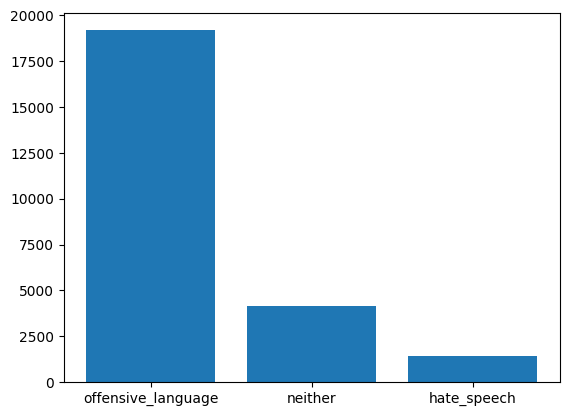

In [71]:
print(df['class'].value_counts())

x_labels = ['offensive_language', 'neither', 'hate_speech']
plt.xticks(range(1, 4), x_labels)
plt.bar(x=range(1,4), height=temp_df.to_list());


# Data Split

In [72]:
train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['class'] )
train, val = train_test_split(train, test_size=0.2, random_state=42, stratify=train['class'] )

# Data transformation

In [73]:
label_map = {0:"hate_speech", 1:"offensive_language", 2:"neither"}

In [74]:
# Use cuda if it's available
if torch.cuda.is_available():      
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [75]:
# Preparing dataset for the distilBert model
class ClassificationDataset(Dataset):
    def __init__(self, text, target, label_map):
        super(ClassificationDataset).__init__()
        self.text = text
        self.target = target
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.max_len = 64
        self.label_map = label_map
      
    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = str(self.text[item])
        text = " ".join(text.split())
        
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True
        )      
        return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [76]:
train_dataset = ClassificationDataset(
    train["tweet"].to_list(),
    train["class"].to_list(),
    label_map
)
val_dataset = ClassificationDataset(
    val["tweet"].to_list(),
    val["class"].to_list(),
    label_map
)
test_dataset = ClassificationDataset(
    test["tweet"].to_list(),
    test["class"].to_list(),
    label_map
)

# DistilBERT model

In [ ]:
class CustomClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.pre_classifier = nn.Linear(self.distilbert.config.dim, 128)
        self.dropout = nn.Dropout(0.2)
        self.classifier1 = nn.Linear(128, 64)
        self.classifier2 = nn.Linear(64, 3)

    def forward(self, input_ids, attention_mask=None, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]
        out = hidden_state[:, 0]
        out = self.pre_classifier(out)
        out = nn.ReLU()(out)
        out = self.dropout(out)
        out = self.classifier1(out)
        out = nn.ReLU()(out)
        out = self.dropout(out)
        logits = self.classifier2(out)
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, 5), labels.view(-1))
        return (loss.mean(), logits)
    
model = CustomClassificationModel() 
#model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)